In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# --- 1. データの読み込み ---
# 訓練データ (2025年のシミュレーションデータ)
train_files = glob.glob('2025_future_test_1/**/*.csv', recursive=True)
train_df_list = [pd.read_csv(file) for file in train_files]
train_df = pd.concat(train_df_list, ignore_index=True)

# テストデータ (2024年の特定レースデータ)
test_files = glob.glob('2025_future_test_1/test_data/2025_austria_RUS_analysis.csv')
test_df_list = [pd.read_csv(file) for file in test_files]
test_df = pd.concat(test_df_list, ignore_index=True)

In [4]:
# --- 2. 前処理と特徴量エンジニアリング ---

# 使用する特徴量のリストを定義
# 順序のあるカテゴリカル特徴量
ordinal_features = ['Compound']
# 順序のないカテゴリカル特徴量
nominal_features = ['engine']
# 数値特徴量
numeric_features = [
    'LapNumber', 'tire_laps', 'TrackTemp', 'AirTemp', 'WindDirection',
    'WindSpeed', 'Humidity', 'Circuit_Length', 'corners',
    'low_speed_corners', 'middle_speed_corners', 'high_speed_corners',
    'accelerator_engine', 'RealGap(s)', 'Rainfall'
]
target_feature = 'degradation'

# 特徴量のリストを結合
features = ordinal_features + nominal_features + numeric_features

# 欠損値を含む行を削除 (データの状況に応じて、平均値などで補完する方法も検討)
train_df.dropna(subset=features + [target_feature], inplace=True)
test_df.dropna(subset=features + [target_feature], inplace=True)

# 説明変数と目的変数を設定
X_train = train_df[features]
y_train = train_df[target_feature]
X_test = test_df[features]
y_test = test_df[target_feature]


# エンコーディングとスケーリングの前処理パイプラインを定義
# Compoundの順序を定義
compound_order = ['SOFT', 'MEDIUM', 'HARD', 'INTERMEDIATE', 'WET']

# ColumnTransformerで各列に適用する処理を定義
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('ord', OrdinalEncoder(categories=[compound_order]), ordinal_features),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ],
    remainder='passthrough' # ここで指定されなかった列はそのまま維持される
)

In [5]:
# --- 3. モデルの学習と評価 ---

# モデルを定義 (ランダムフォレスト)
model = RandomForestRegressor(random_state=42)

# 前処理とモデル学習を連結したパイプラインを作成
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

# パイプラインを使ってモデルを学習
pipeline.fit(X_train, y_train)

# 予測
y_pred = pipeline.predict(X_test)

# モデルの評価
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.014982630889166676
R^2 Score: 0.7977525618947421


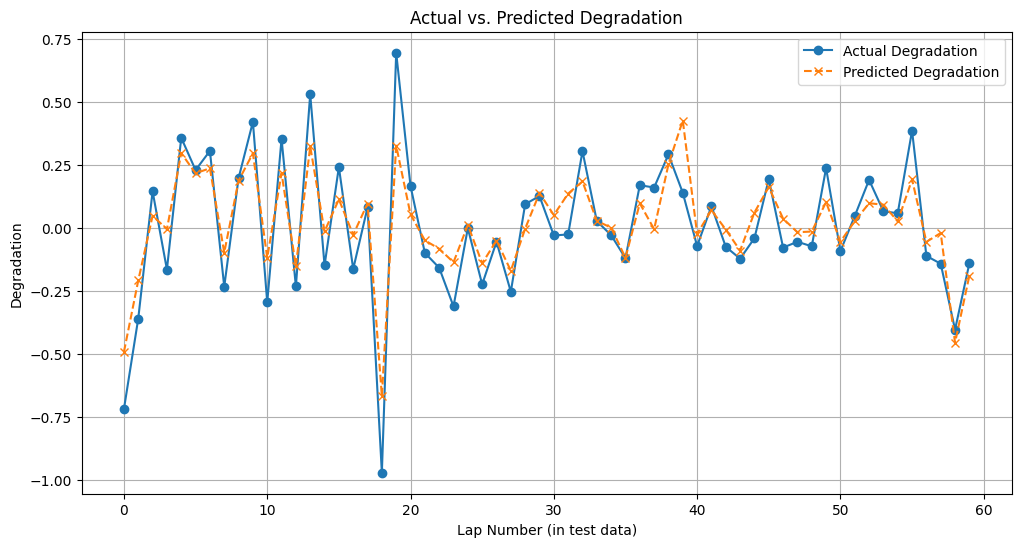

In [6]:
# --- 4. 結果の可視化 ---

# 1. 実測値と予測値の比較プロット
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Degradation', marker='o', linestyle='-')
plt.plot(y_pred, label='Predicted Degradation', marker='x', linestyle='--')
plt.xlabel('Lap Number (in test data)')
plt.ylabel('Degradation')
plt.title('Actual vs. Predicted Degradation')
plt.legend()
plt.grid(True)
plt.show()

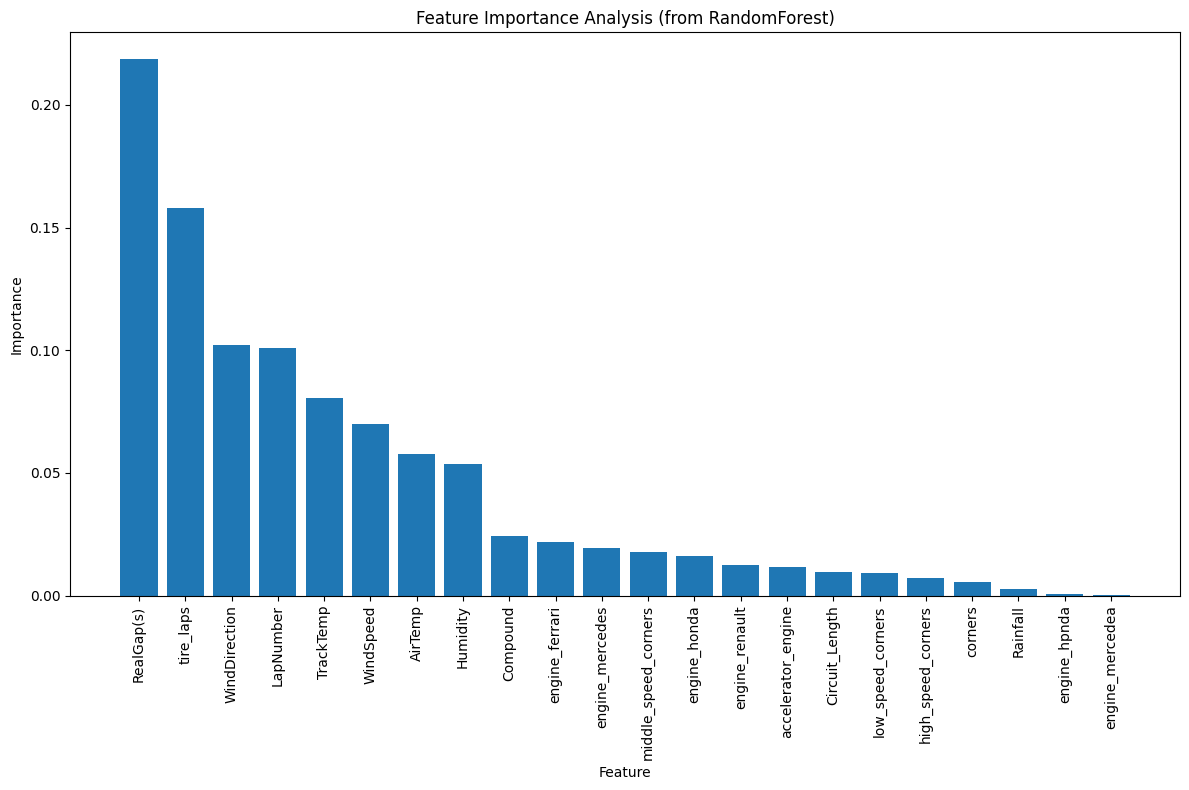

In [7]:
# 2. 特徴量の重要度の可視化
# パイプラインからOneHotEncoderの変換後の特徴量名を取得
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['nom'].get_feature_names_out(nominal_features)

# 全ての特徴量名を結合
all_feature_names = numeric_features + ordinal_features + list(ohe_feature_names)

# 学習済みモデルから重要度を取得
importances = pipeline.named_steps['regressor'].feature_importances_

# データフレームにまとめる
feature_importances = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# プロット
plt.figure(figsize=(12, 8))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Analysis (from RandomForest)')
plt.xticks(rotation=90) # ラベルを90度回転
plt.tight_layout() # レイアウトを調整
plt.show()

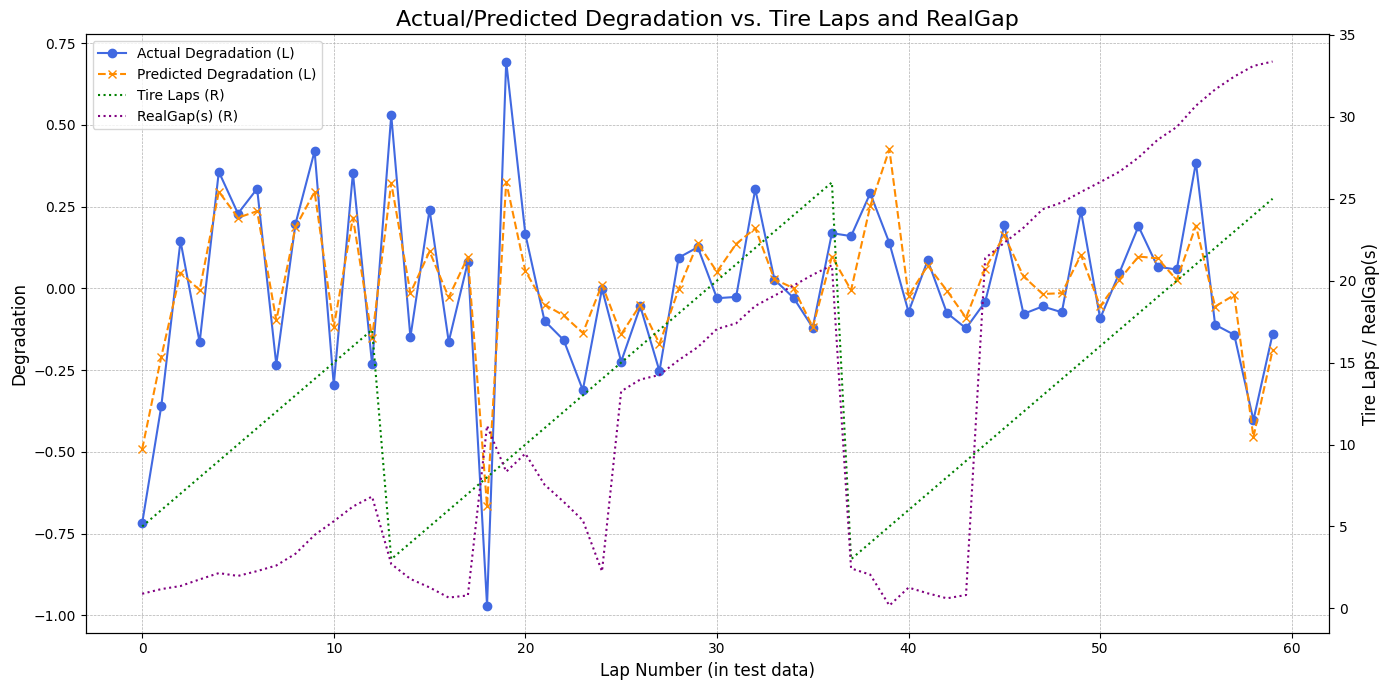

In [8]:
# --- 4. 結果の可視化 ---

# 1. 実測値、予測値、および他の特徴量を重ねてプロット (2軸グラフ)

# グラフの фигура (fig) と、最初の Y軸 (ax1) を作成
fig, ax1 = plt.subplots(figsize=(14, 7))

# --- 左側のY軸 (ax1) に Degradation をプロット ---
# 実測値
ax1.plot(y_test.values, label='Actual Degradation (L)', marker='o', linestyle='-', color='royalblue')
# 予測値
ax1.plot(y_pred, label='Predicted Degradation (L)', marker='x', linestyle='--', color='darkorange')

# ax1 のラベルと色を設定
ax1.set_xlabel('Lap Number (in test data)', fontsize=12)
ax1.set_ylabel('Degradation', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth=0.5) # グリッドを主軸に引く

# --- 右側のY軸 (ax2) に tire_laps と RealGap(s) をプロット ---
# ax1 と X軸を共有する新しい Y軸 (ax2) を作成
ax2 = ax1.twinx()

# X_testからデータを取得（y_testと同じインデックスを持つことを確認）
ax2.plot(X_test['tire_laps'].values, label='Tire Laps (R)', linestyle=':', color='green')
ax2.plot(X_test['RealGap(s)'].values, label='RealGap(s) (R)', linestyle=':', color='purple')

# ax2 のラベルと色を設定
ax2.set_ylabel('Tire Laps / RealGap(s)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')


# --- 凡例（Legend）を一つにまとめる ---
# 両方の軸の凡例情報を取得して、一つの凡例として表示
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# グラフ全体のタイトルとレイアウト調整
plt.title('Actual/Predicted Degradation vs. Tire Laps and RealGap', fontsize=16)
fig.tight_layout()  # ラベルが重ならないように自動調整
plt.show()